In [11]:
import os
import torch
import matplotlib.pyplot as plt
import nibabel as nb
import numpy as np
import time
import cv2
from tqdm import tqdm
import _3dpu_mehdi as mehdi
from _3dpu import *

In [2]:
device = 'cpu'
if torch.cuda.is_available() :
    device = 'cuda'

In [3]:
!pip3 install ipympl
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\0\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [13]:
chemin = r"C:\Users\0\OneDrive\Documents\Montréal 4A\Les études\Chair AI-SCALE\ph_1.nii"
chemin_mag = r"C:\Users\0\OneDrive\Documents\Montréal 4A\Les études\Chair AI-SCALE\mag_1.nii"
chemin2 = r"C:\Users\0\Downloads\TGVQSM-plus\TGVQSM-master-011045626121baa8bfdd6633929974c732ae35e3\test_data\epi3d_test_phase.nii"
chemin3 = r"C:\Users\0\Downloads\20170327_qsm2016_recon_challenge\20170327_qsm2016_recon_challenge\data\phs_wrap.nii"
phase_image = nb.load(chemin)
mag_imgae = nb.load(chemin_mag)
phase_image2 = nb.load(chemin2)
phase_image3 = nb.load(chemin3)
x_min,x_max = 50,130
y_min,y_max = 50,130
z_min,z_max = 20,60
t = 1
data = phase_image.get_data()[:,:,:,t]
mag_data = mag_imgae.get_data()[:,:,:,t]

C:\Users\0\AppData\Local\Temp\ipykernel_16064\834609239.py:13: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = phase_image.get_data()[:,:,:,t]
C:\Users\0\AppData\Local\Temp\ipykernel_16064\834609239.py:14: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mag_data = mag_imgae.get_data()[:,:,:,t]


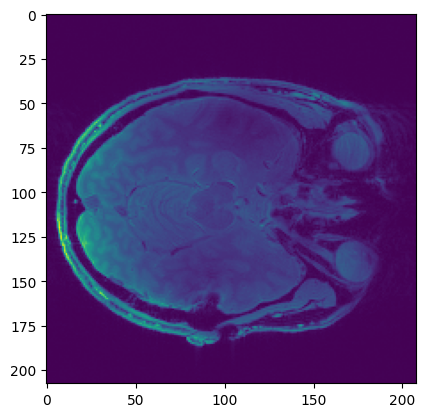

In [14]:
plt.figure()
plt.imshow(mag_data[:,:,10])

# **Brain Extraction Using U-Net**   (3D and Auto)

# Otsu Separation

In [7]:
i,j,k = 0,0,0
Z = np.array(mag_data)
Z = Z.flatten()
values,n = np.unique(Z,return_counts=True)
proba = n/len(Z)

In [16]:
def threshold_image(im,th):
    thresholded_im = np.zeros(im.shape)
    thresholded_im[im >= th] = 1
    return thresholded_im

In [17]:
def compute_otsu_criteria(im, th):
    thresholded_im = threshold_image(im,th)
    nb_pixels = im.size
    nb_pixels1 = np.count_nonzero(thresholded_im)
    weight1 = nb_pixels1 / nb_pixels
    weight0 = 1 - weight1
    if weight1 == 0 or weight0 == 0:
        return np.inf
    val_pixels1 = im[thresholded_im == 1]
    val_pixels0 = im[thresholded_im == 0]
    var0 = np.var(val_pixels0) if len(val_pixels0) > 0 else 0
    var1 = np.var(val_pixels1) if len(val_pixels1) > 0 else 0
    return weight0 * var0 + weight1 * var1



In [35]:
def find_best_threshold(im):
    threshold_range = range(int(np.max((im)))+1)
    criterias = [compute_otsu_criteria(im, th) for th in tqdm(threshold_range)]
    best_threshold = threshold_range[np.argmin(criterias)]
    return best_threshold

# UNet Model

In [2]:
import torch.nn as nn

class Conv3DBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, bottleneck = False) -> None:
        super(Conv3DBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_channels= in_channels, out_channels=out_channels//2, kernel_size=(3,3,3), padding=1)
        self.bn1 = nn.BatchNorm3d(num_features=out_channels//2)
        self.conv2 = nn.Conv3d(in_channels= out_channels//2, out_channels=out_channels, kernel_size=(3,3,3), padding=1)
        self.bn2 = nn.BatchNorm3d(num_features=out_channels)
        self.relu = nn.ReLU()
        self.bottleneck = bottleneck
        if not bottleneck:
            self.pooling = nn.MaxPool3d(kernel_size=(2,2,2), stride=2)

    def forward(self, input):
        res = self.relu(self.bn1(self.conv1(input)))
        res = self.relu(self.bn2(self.conv2(res)))
        out = None
        if not self.bottleneck:
            out = self.pooling(res)
        else:
            out = res
        return out, res

In [8]:
class UpConv3DBlock(nn.Module):

    def __init__(self, in_channels, res_channels=0, last_layer=False, num_classes=None) -> None:
        super(UpConv3DBlock, self).__init__()
        assert (last_layer==False and num_classes==None) or (last_layer==True and num_classes!=None), 'Invalid arguments'
        self.upconv1 = nn.ConvTranspose3d(in_channels=in_channels, out_channels=in_channels, kernel_size=(2, 2, 2), stride=2)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm3d(num_features=in_channels//2)
        self.conv1 = nn.Conv3d(in_channels=in_channels+res_channels, out_channels=in_channels//2, kernel_size=(3,3,3), padding=(1,1,1))
        self.conv2 = nn.Conv3d(in_channels=in_channels//2, out_channels=in_channels//2, kernel_size=(3,3,3), padding=(1,1,1))
        self.last_layer = last_layer
        if last_layer:
            self.conv3 = nn.Conv3d(in_channels=in_channels//2, out_channels=num_classes, kernel_size=(1,1,1))
            
        
    def forward(self, input, residual=None):
        out = self.upconv1(input)
        if residual!=None: out = torch.cat((out, residual), 1)
        out = self.relu(self.bn(self.conv1(out)))
        out = self.relu(self.bn(self.conv2(out)))
        if self.last_layer: out = self.conv3(out)
        return out

In [9]:
class UNet3D(nn.Module):
    
    def __init__(self, in_channels, num_classes, level_channels=[32, 32], bottleneck_channel=64) -> None:
        super(UNet3D, self).__init__()
        level_1_chnls, level_2_chnls = level_channels[0], level_channels[1]
        self.a_block1 = Conv3DBlock(in_channels=in_channels, out_channels=level_1_chnls)
        self.a_block2 = Conv3DBlock(in_channels=level_1_chnls, out_channels=level_2_chnls)
        
        self.bottleNeck = Conv3DBlock(in_channels=level_2_chnls, out_channels=bottleneck_channel, bottleneck= True)
        
        self.s_block2 = UpConv3DBlock(in_channels=bottleneck_channel, res_channels=level_2_chnls)
        self.s_block1 = UpConv3DBlock(in_channels=level_2_chnls, res_channels=level_1_chnls, num_classes=num_classes, last_layer=True)

    
    def forward(self, input):
        out, residual_level1 = self.a_block1(input)
        out, residual_level2 = self.a_block2(out)
        out, _ = self.bottleNeck(out)
        out = self.s_block2(out, residual_level2)
        out = self.s_block1(out, residual_level1)
        return out

In [10]:
model = UNet3D(in_channels = 1, num_classes = 1)
mask = (mag_data > 46)
mask = torch.Tensor(mask).unsqueeze(0).unsqueeze(0)
cv3 = nn.Conv3d(in_channels= 1, out_channels=3//2, kernel_size=(3,3,3), padding=1)
resp = model(mask)

# Using Erosion dilation

(array([7.062430e+05, 3.900000e+01, 2.600000e+01, 5.800000e+01,
        5.200000e+01, 7.500000e+01, 5.500000e+01, 9.300000e+01,
        6.600000e+01, 1.050000e+02, 1.170000e+02, 8.300000e+01,
        1.560000e+02, 1.200000e+02, 2.100000e+02, 1.390000e+02,
        2.480000e+02, 2.070000e+02, 3.170000e+02, 2.790000e+02,
        4.370000e+02, 5.540000e+02, 4.270000e+02, 6.630000e+02,
        5.120000e+02, 8.750000e+02, 6.160000e+02, 1.046000e+03,
        8.160000e+02, 1.313000e+03, 1.604000e+03, 1.147000e+03,
        2.097000e+03, 1.481000e+03, 2.613000e+03, 1.951000e+03,
        3.196000e+03, 2.461000e+03, 4.013000e+03, 3.110000e+03,
        5.464000e+03, 6.369000e+03, 4.826000e+03, 8.113000e+03,
        6.041000e+03, 1.021900e+04, 7.620000e+03, 1.262000e+04,
        9.163000e+03, 1.559600e+04, 1.709100e+04, 1.247000e+04,
        2.035500e+04, 1.474400e+04, 2.401400e+04, 1.743300e+04,
        2.837500e+04, 2.034900e+04, 3.193300e+04, 2.238300e+04,
        3.551900e+04, 3.843300e+04, 2.73

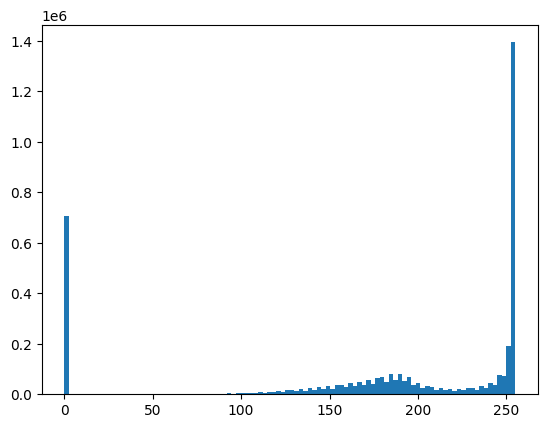

In [16]:
# # plt.figure()
# # plt.imshow(resp[0,0,:,:,15].detach().numpy())

# Z = 100*np.array(resp.detach().numpy())
# Z = Z.flatten()


# th = find_best_threshold(Z)
# th
mask = mag_data
img= mask
img = np.array(img*255,dtype = np.uint8)
plt.figure()


# dilation = cv2.dilate(img,kernel,iterations = 1)


kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(img,np.ones((10,10),np.uint8),iterations = 1)
dilation = cv2.dilate(erosion,np.ones((10,10),np.uint8),iterations = 1)

Z = img.flatten()
plt.hist(Z,bins = 100)




In [21]:

mask = np.array(mag_data > 46,np.uint8)[:,:,45]
image = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

In [23]:
image.shape

(208, 208, 3)

In [25]:
import cv2
import numpy as np;
 
# Read image
im_in = image
 
# Threshold.
# Set values equal to or above 220 to 0.
# Set values below 220 to 255.
 
th, im_th = cv2.threshold(im_in, 220, 255, cv2.THRESH_BINARY_INV);
 
# Copy the thresholded image.
im_floodfill = im_th.copy()
 
# Mask used to flood filling.
# Notice the size needs to be 2 pixels than the image.
h, w = im_th.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
 
# Floodfill from point (0, 0)
cv2.floodFill(im_floodfill, mask, (0,0), 255);
 
# Invert floodfilled image
im_floodfill_inv = cv2.bitwise_not(im_floodfill)
 
# Combine the two images to get the foreground.
im_out = im_th | im_floodfill_inv
 
# Display images.
cv2.imshow("Thresholded Image", im_th)
cv2.imshow("Floodfilled Image", im_floodfill)
cv2.imshow("Inverted Floodfilled Image", im_floodfill_inv)
cv2.imshow("Foreground", im_out)
cv2.waitKey(0)

# Begin Detangling